# Glacier area estimation using NDSI

## Introduction

This notebook will walk you through the process of estimating glacier area in summer season with the help of [NDSI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/) (Normalized Difference Snow Index) and comparing the glacier size change over selected years. You'll learn how to download Sentinel-2 imagery using Copernicus browser, how to calculate the NDSI and how to work with **Rasterio**, which is a Python package intended for processing geospatial raster data.

The basis for this notebook is the "GeoPython: Glacier area calculation" semester project by Michal Potočiar and Adam Tóth in 2023 during the course "Advanced methods of remote sensing" (KGI/MEDPZ) at the Department of Geoinformatics, Palacký University in Olomouc.

Prerequisites:
- packages [**Rasterio**](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://rasterio.readthedocs.io/&ved=2ahUKEwjxyrW60KmFAxXi2QIHHftmDCQQFnoECAcQAQ&usg=AOvVaw3OaEklHNNg1bhKOHQs9SJO), [**Shapely**](https://shapely.readthedocs.io/en/stable/manual.html), [**OSMnx**](https://osmnx.readthedocs.io/en/stable/index.html), [**NumPy**](https://numpy.org/), [**Matplotlib**](https://matplotlib.org/), [**os**](https://docs.python.org/3/library/os.html) and [**re**](https://docs.python.org/3/library/re.html)

The workflow is divided into the following sections:
- [Sentinel-2 download](#sentinel)
- [Data preparation and editing](#data)
- [NDSI calculation and glacier area estimation](#calculation)
- [Visualizations of glacier area change](#visual)

Together with this notebook in the /data/ directory there is Copernicus Sentinel data 2018-2023. 

## Sentinel-2 download <a id='sentinel'></a>

The area of interest will be the [Aletschgletscher](https://www.aletscharena.ch/en/world-natural-heritage-site/great-aletsch-glacier). It is located in between Swiss cities Bern and Lugano and it's the largest glacier in the Alps which makes it suitable to find it on satellite images and track its area size over the years.

Feel free to choose a different glacier and use the code in the cells below to do the same for other area of interest.

Go to the [Copernicus browser](https://dataspace.copernicus.eu/browser/) and login with your Copernicus Data Space Ecosystem account. The login button is in the upper left corner. Then zoom to Switzerland and draw a rectangle around the Aletschgletscher. When searching for the satellite images, you will only get the ones that cover the rectangle.

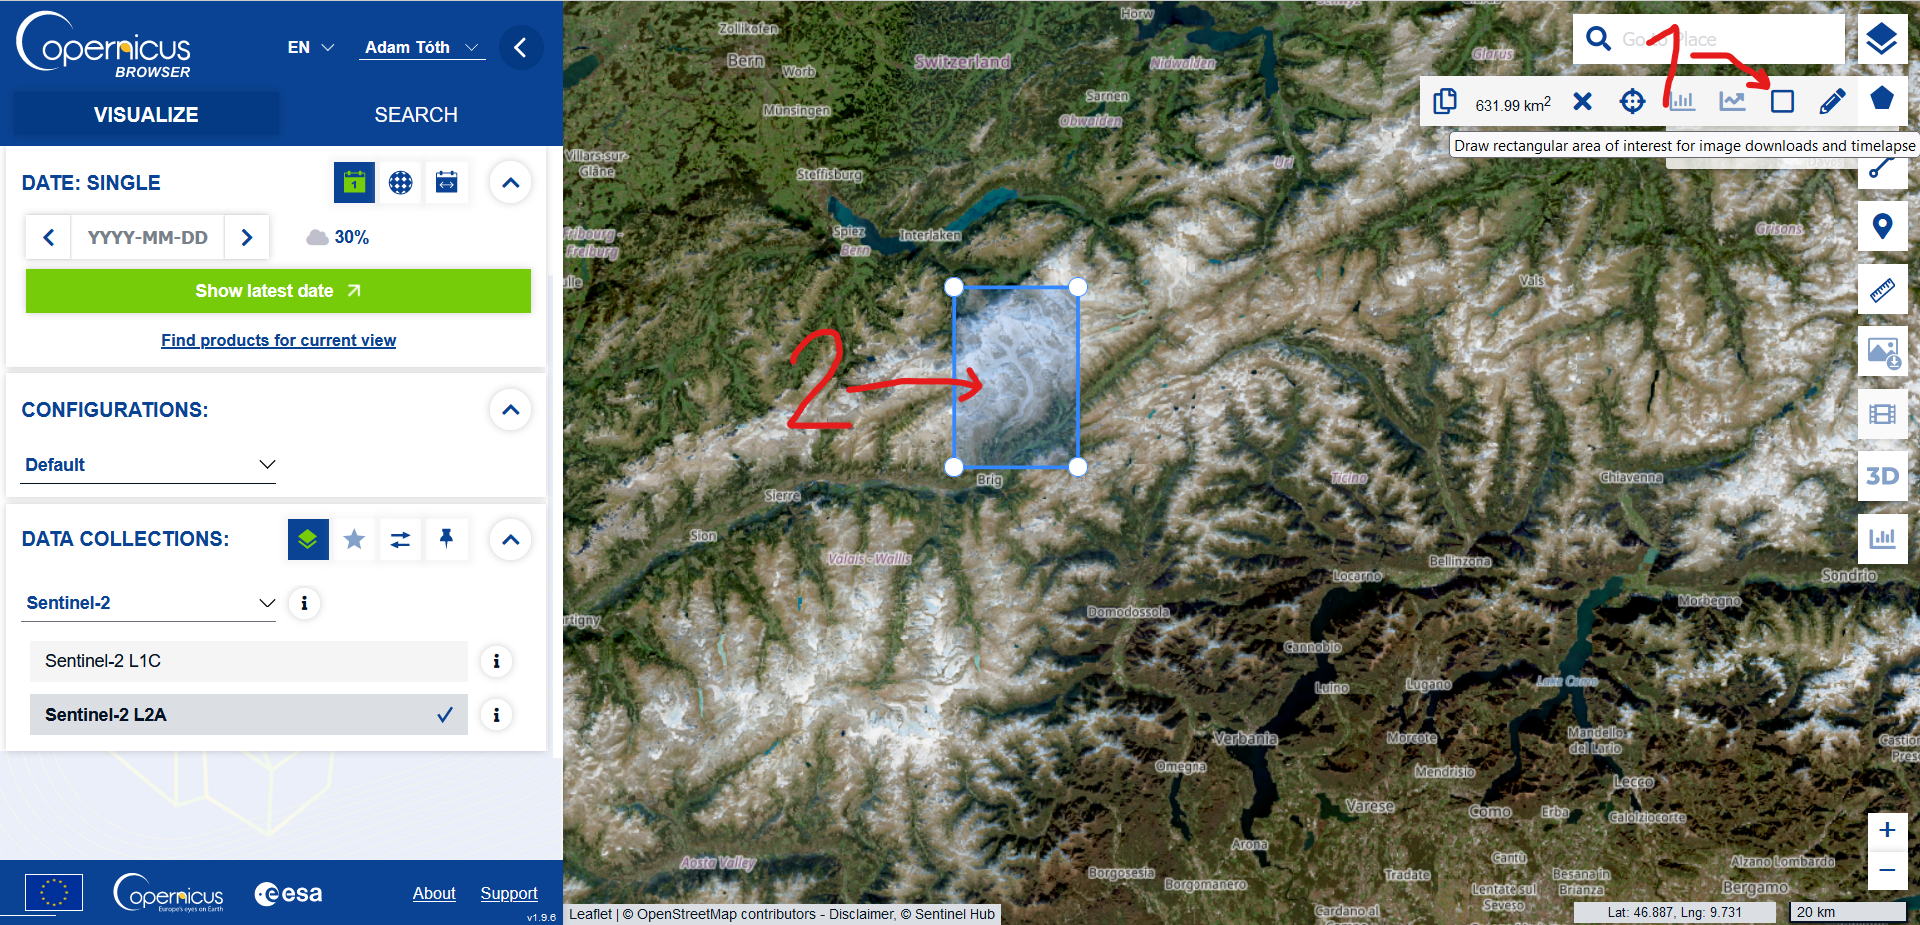

Swith to the Search tab and set the Sentinel-2 filters as shown in the picture below.

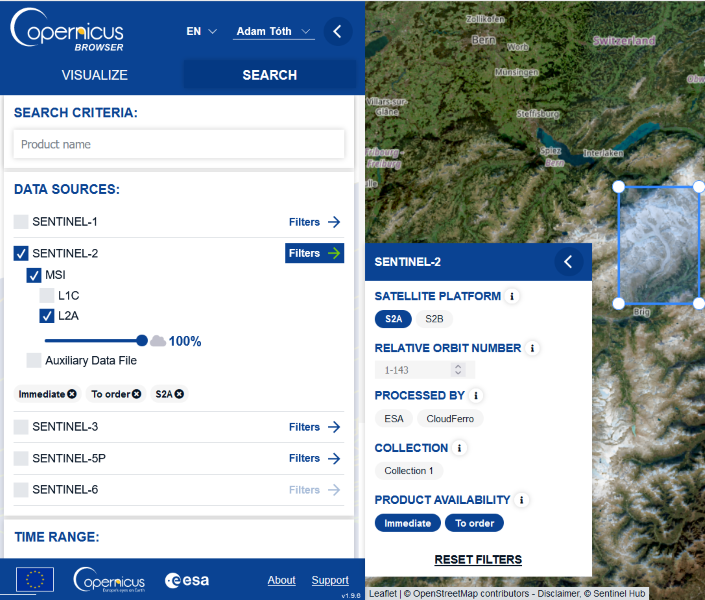

Scroll down the Search tab and set the time range to search for images taken in July 2023. Then click the green Search button.

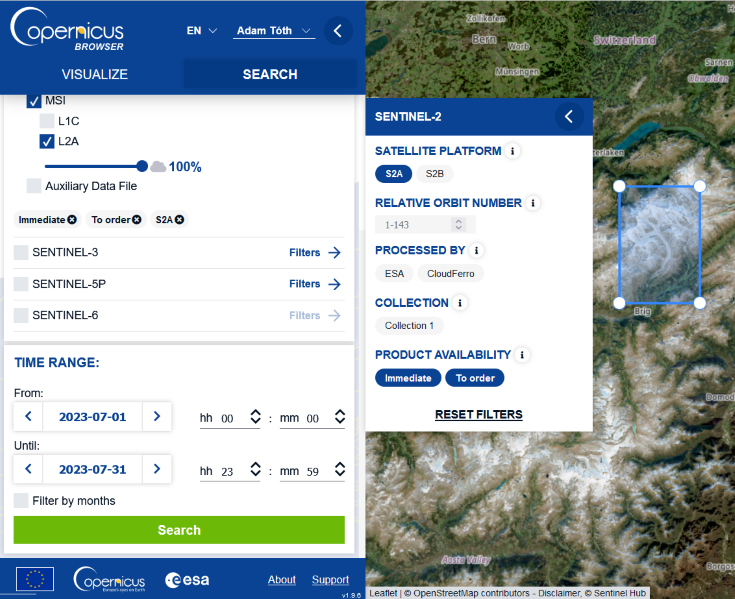

It will give you satellite images that meet the search criteria. Ideally choose an image taken in the middle of July. Click on the product info button to check the cloud cover percentage and if clouds don't cover the Aletschgletscher area, download it.

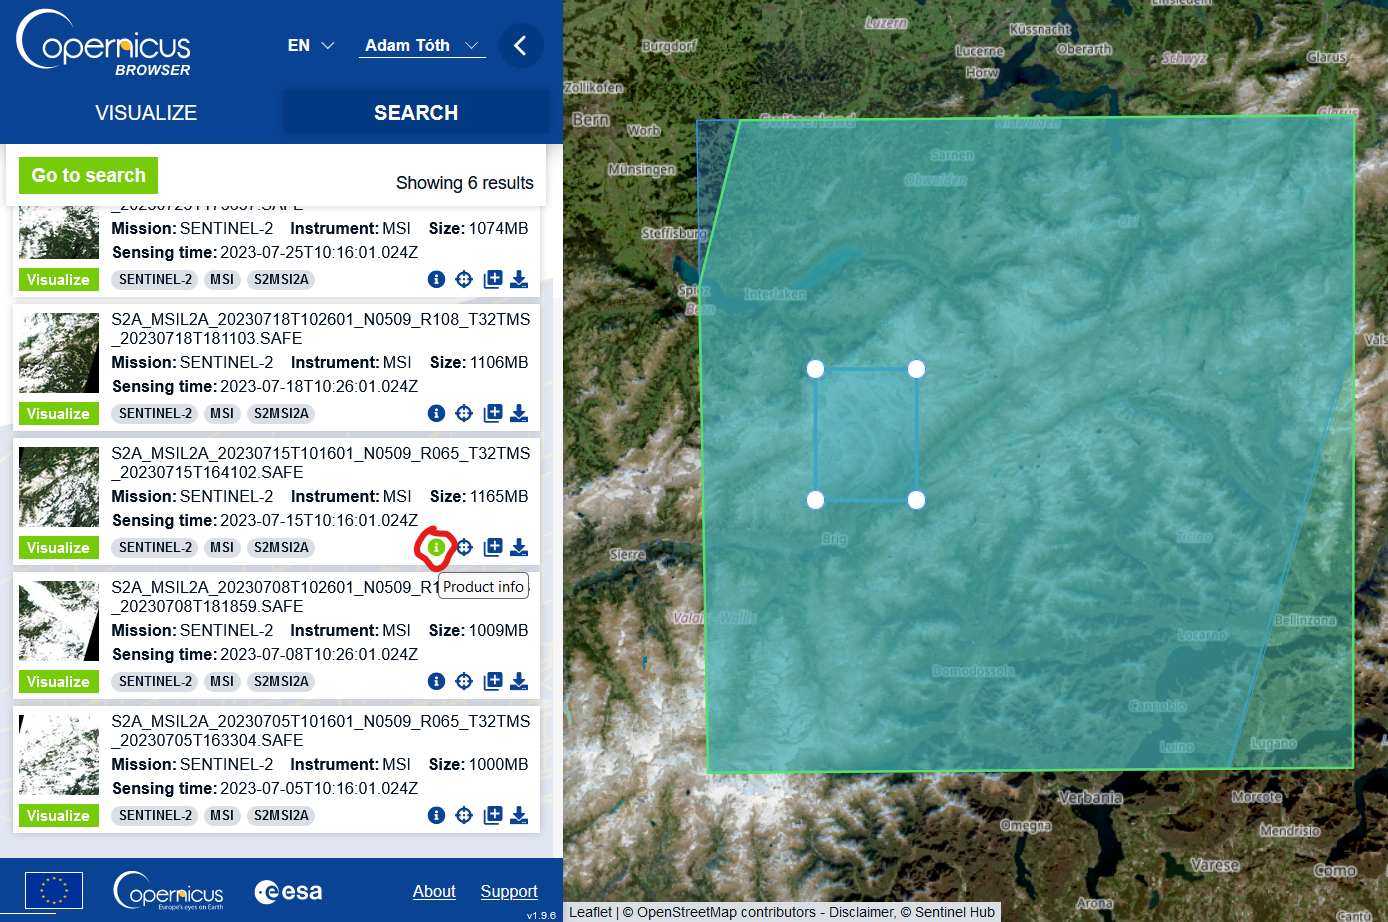

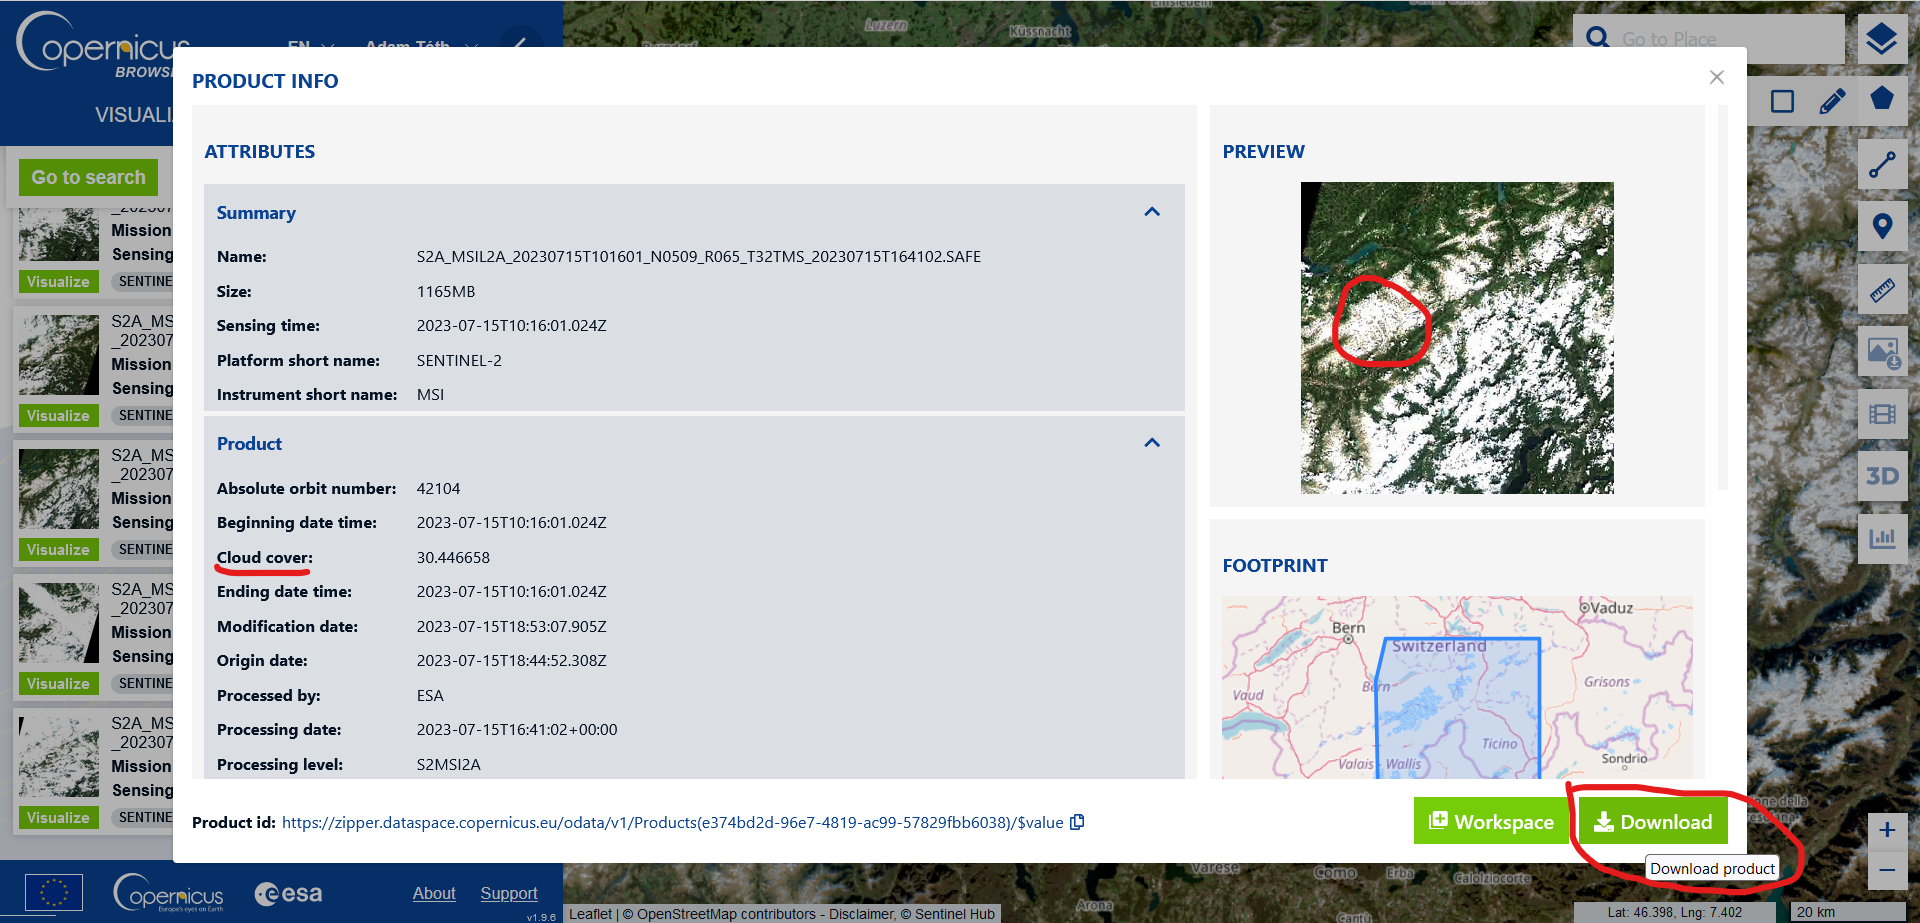

Repeat this process for years 2018-2022, so you'll have Sentinel-2 images taken in July for 6 years in the end.

Create a new folder in the directory where this notebook is located and name it **'data'**. Unzip the downloaded Sentinel-2 folders into that folder. 

If you have enough memory space and/or you would like to keep all downloaded files, feel free to do so, but for purposes of this notebook you can delete everything but 20 m bands B03 and B11. These are located in '/S2A_.../GRANULE/L2A.../IMG_DATA/R20m/' and the bands end with 'B03_20m.jp2' and 'B11_20m.jp2' respectively.   

## Data preparation and editing <a id="data"></a>

Import necessary packages. You'll need **Rasterio** to read, process and write geospatial raster data. **Shapely** and **OSMnx** will help you retrieve the Aletschgletscher polygon. Package **re** enables to use regular expressions and in this case it is used to find the date when the satellite image was taken from its file name. **NumPy** and **os** will help with calculation and accessing directories and files, respectively. **Matplotlib** will be used in the end to produce a plot of the glacier area size change over the years.

In [1]:
import rasterio
from rasterio.mask import mask
from rasterio import plot
from shapely.geometry import shape
import osmnx as ox
import os
import re
import numpy as np
import matplotlib.pyplot as plt

This next code cell sets the *division* and *invalid* errors to be ingored. It is because of the NDSI calculation later in the notebook which produces such error, but the NDSI is calculated correctly. 

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

Use [**os.getcwd()**](https://www.w3schools.com/python/ref_os_getcwd.asp) to get the path to the current directory where this notebook is located. Define variable ```datadir``` as the current directory + folder 'data' where you store downloaded image bands.

In [21]:
cwd = os.getcwd()
datadir = cwd + "/data"

Walk through the folder 'data' and save the B03 and B11 20 m bands into lists named ```bands_B03``` and ```bands_B11```. Functions [**os.walk()**](https://www.geeksforgeeks.org/os-walk-python/), [**os.path.join()**](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.geeksforgeeks.org/python-os-path-join-method/&ved=2ahUKEwig4IWbuKqFAxUZ9bsIHSoQAagQFnoECAYQAQ&usg=AOvVaw0tCTDO25DAmL_SejnHtvZd) and [**endswith()**](https://www.w3schools.com/python/ref_string_endswith.asp) are helpful in this case. Print the lists and notice the difference when printing with ```print()``` and printing by only typing the variable.

In [ ]:
bands_B03 = []
bands_B11 = []

for subdir, dirs, files in os.walk(datadir):
    for file in files:
        if os.path.join(subdir, file).endswith("B03_20m.jp2"):
            bands_B03.append(os.path.join(subdir, file))
        if os.path.join(subdir, file).endswith("B11_20m.jp2"):
            bands_B11.append(os.path.join(subdir, file))

print(bands_B03)
bands_B11

Fill the list ```unique_dates``` with dates of the downloaded satellite images. Use [**re.search**](https://docs.python.org/3/library/re.html#re.search) to find a date in the file name of Sentinel-2 band. Print the dates in the end.

In [ ]:
unique_dates = []
# loop through the bands in list source
for item in bands_B03:
    # find a date in the band name using regular expression 
    # band name example: T32TMS_20180701T102021_B03_20m.jp2
    match = re.search(r'[A-Za-z\d]+_(\d+)T', item)
    # if there is a date in the band name
    if match:
        # return the string matched by the regular expression
        date = match.group(1)
        # add date to the list unique_dates
        unique_dates.append(date)

unique_dates

### Get the area of interest polygon

Now you will get a GeoDataFrame of the Aletschgletscher using [**OSMnx.geocode_to_gdf()**](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.geocoder.geocode_to_gdf) and save it to the variable ```area```.

In [7]:
area = ox.geocode_to_gdf("Aletschgletscher")
area

geometry  bbox_north  bbox_south  \
0  POLYGON ((8.03319 46.40272, 8.03331 46.40242, ...    46.50064   46.402341   

   bbox_east  bbox_west  place_id osm_type    osm_id        lat       lon  \
0   8.086568   8.033193  61100072      way  42742456  46.451632  8.077508   

     class     type  place_rank  importance addresstype             name  \
0  natural  glacier          22    0.428395     glacier  Aletsch Glacier   

                                        display_name  
0  Aletsch Glacier, Fieschertal, Goms, Wallis, Sw...

This ```area``` GeoDataFrame is in the EPSG:4326 coordinate reference system (WGS 1984). Get the coordinate reference system of the downloaded images by opening one image band with [**rasterio.open()**](https://rasterio.readthedocs.io/en/stable/api/rasterio.html#rasterio.open) and getting its metadata with [**meta.copy()**](https://rasterio.readthedocs.io/en/stable/topics/reproject.html). It returns a dicionary where one key is 'crs'. Print the value of this key.

In [8]:
with rasterio.open(bands_B03[0]) as band:
    band_metadata = band.meta.copy()

band_metadata['crs']

CRS.from_epsg(32632)

Sentinel-2 images for Switzerland are in the EPSG:32632 coordinate reference system (WGS 84 / UTM zone 32N). Therefore it's necessary to project the ```area``` GeoDataFrame into that coordinate reference system. You can do that using [**to_crs()**](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) function. Then create a shapely polygon from the GeoDataFrame by [**shape()**](https://shapely.readthedocs.io/en/stable/manual.html#shapely.geometry.shape) function. Print the ```area``` now.

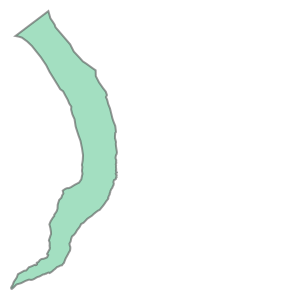

In [9]:
area.to_crs(crs=band_metadata['crs'], inplace=True)
area = shape(area.loc[0, 'geometry'])
area

### Image bands clipping

Define a function named ```clip_raster(bands)```. This function will clip all image bands in the list provided in the input parameter ```bands```. The clipping polygon will be the ```area``` polygon and the clipping function will be [**mask()**](https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html). This function returns two outputs:
- *masked*: actual clipped raster
- *out_transform*: information for mapping pixel coordinates in *masked* to another coordinate system
Save both into their respective lists, *masked* in ```oi``` variable to the ```out_image``` list and *out_transform* in ```ot``` variable into the ```out_transform``` list.

After that save also the metadata of each image band into the ```out_meta``` list using **meta.copy()** function and update them by [**update()**]() function.

The function ```clip_raster(bands)``` will return 2 lists: ```out_image``` and ```out_meta```.

In [10]:
def clip_raster(bands):
    # define empty lists
    out_image = []
    out_transform = []
    out_meta = []
    
    # loop through all the image bands
    for i in range(len(bands)):
        with rasterio.open(bands[i]) as src:
            # clipping the current image band by area of interest
            oi, ot = mask(src, [area], crop=True)
            out_image.append(oi)
            out_transform.append(ot)
            # retrieve metadata of the current image band
            om = src.meta.copy()
            out_meta.append(om)

        # metadata update of the clipped image band
        out_meta[i].update({"driver": "GTiff",
                        "height": out_image[i].shape[1],
                        "width": out_image[i].shape[2],
                        "transform": out_transform[i],
                        "dtype": "float32"
                        })
        out_image[i] = out_image[i].astype('float32')

    return(out_image, out_meta)

Run the function above for ```bands_B03``` and ```bands_B11```.

In [11]:
clipped_B03_image, clipped_B03_meta = clip_raster(bands_B03)
clipped_B11_image, clipped_B11_meta = clip_raster(bands_B11)

Print the 1st elements of ```clipped_B03_meta``` and ```clipped_B03_image``` so you see how metadata and images are represented and stored in Python.

In [ ]:
print(clipped_B03_meta[0])
print(clipped_B03_image[0])

## NDSI calculation and glacier area estimation <a id='calculation'></a>

Now you've got all necessary data ready to calculate the NDSI and estimate the glacier area, just create a directory **'ndsi'** where you will write and save rasters with calculated NDSI. Use [**os.path.exists()**](https://www.geeksforgeeks.org/python-os-path-exists-method/) to make sure such a folder doens't already exists in your current working directory and then create that folder by [**os.mkdir()**](https://www.geeksforgeeks.org/python-os-mkdir-method/).

In [29]:
if os.path.exists(cwd+'/ndsi'):
    print(f'The "ndsi" folder already exists in {cwd}')
else:
    os.mkdir('ndsi')
    print(f'The "ndsi" folder was successfully created in {cwd}')

The "ndsi" folder already exists in d:\ArcGIS_Notebooks_thesis\glacier_area


[NDSI](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndsi/) (Normalized Difference Snow Index) for Sentinel-2 is calculated like this:

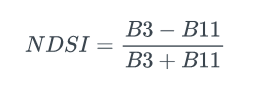

It is a ratio of subtraction and addition of 2 bands: green band (B3) and short wave infrared band (B11). Snow has the highest radiation reflectance in the visible band, represented in NDSI by the green band. On the other hand, snow absorbs most of the radiation in the short wave infrared band. That's why these 2 bands form the index. NDSI values can be in range from -1 to 1.

Now you are maybe asking a question: why do we use the index for detecting snow and not for the ice or glaciers? You can use NDSI for detection of ice and glaciers as well, as you can read in the article [Spectral Indices with multispectral satellite data](https://www.geo.university/pages/blog?p=spectral-indices-with-multispectral-satellite-data) published at Geo University: "NDSI is commonly used in snow/ice cover mapping applications and can also be used, subsidiary, in glacier monitoring" (Dimitris Sykas, 2020). There is also an index specifically developed for mapping glaciers, the [NDGI](https://medium.com/@dimsyk/glacier-mapping-using-earth-observation-satellites-950da8f83945) (Normalized Difference Glacier Index), but with this index it is difficult to find clear thresholds that will filter out the glaciers from other surfaces. 

And how to determine which pixels are snow/ice and which not after the NDSI calculation? [Sentinel experts](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview) already explored the thresholds: "pixels with NDSI values exceeding NDSI T2 threshold (**0.42**) are considered as 'snow' pixels (snow probability equal to 1.0)" (Level-2A Algorithm Overview).

Please keep in mind that this method for estimating the glacier area is very simple and it is not a precise calculation, it's rather an estimation. To get to more precise results it is necessary to do a lot more research and use better methodology than just calculating the NDSI.

In [ ]:
# define an empty list glacier area - you will store the glacier area for every year in this list
glacier_area = []

# let i take values from 0 to half of the source list length 
for i in range(len(clipped_B11_image)):
    ndsi = (clipped_B03_image[i] - clipped_B11_image[i]) / (clipped_B03_image[i] + clipped_B11_image[i])

    # reclassification: pixels with NDSI greater than 0.42 are assigned value 1 = glacier pixels, 
    # the rest is assigned value 0 = no glacier pixels
    ndsi[(ndsi > 0.42)] = 1.0
    ndsi[(ndsi <= 0.42)] = 0.0

    # glacier area calculation: count the number of pixels classified as glacier
    glacier_pixels_count = np.sum(ndsi == 1.0)
    # this number is multiplied by the pixel size, in this case 400 m2, because the image bands have
    # 20 m spatial resolution (20x20=400), then it's divided by 1 million so the final glacier size is in km2
    glacier_area.append((glacier_pixels_count * 400) / 1000000)
    date = unique_dates[i]
    print(f"glacier area on {date[6:] + '.' + date[4:6] + '.' + date[:4]}: {glacier_area[i]} km²")

    # save calculated NDSI as a raster file named ndsi_date.tif
    with rasterio.open(cwd + f'/ndsi/ndsi_{unique_dates[i]}.tif', 'w', **clipped_B03_meta[i]) as dst:
        dst.write(ndsi)

## Visualizations of glacier area change <a id='visual'></a>

It is visible from the printed statements above that the glacier area is decreasing between years 2018 and 2023. Let's visualize it by 2 plots.

The first one will be a series of NDSI plots for all years where green color represents ice and blue color represents surface with no ice. You will be able to see the places where the ice is melting. 

Initialize 6 [**subplots()**](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) and save the axes into a tuple named ```ax_tuple```. The run a for loop which will open the NDSI tif file for each year and plot it using the function [**plot.show()**](https://rasterio.readthedocs.io/en/stable/api/rasterio.plot.html#rasterio.plot.show).

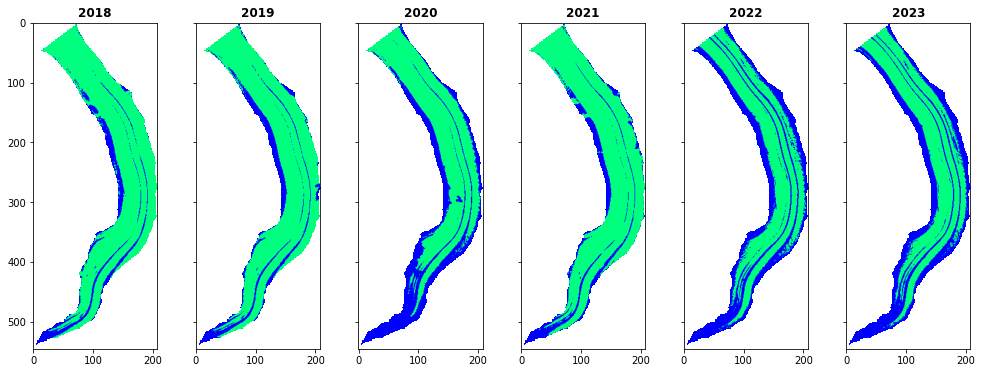

In [28]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(ncols=6, nrows=1, figsize=(17, 6), sharex=True, sharey=True)
ax_tuple = (ax1, ax2, ax3, ax4, ax5, ax6)

for i in range(len(unique_dates)):
    src = rasterio.open(cwd + f'/ndsi/ndsi_{unique_dates[i]}.tif')
    plot.show((src, 1), cmap='winter', ax=ax_tuple[i], title=unique_dates[i][:4], with_bounds=False)
    src.close()

This next cell will calculate and the difference in area size between the first and last year (area in 2018 - area in 2023).

In [ ]:
# calculate the difference in glacier area between the first year and last year
difference = glacier_area[0]-glacier_area[len(glacier_area)-1]
if difference > 0:
    print(f"The glacier has shrunk by {difference} km².")
elif difference < 0:
    print(f"The glacier has increased by {abs(difference)} km².")
else:
    print("The glacier hasn't change.")

Prepare the data for the last plot. Fill list ```years``` with the 6 years and the list ```values``` with the glacier area size for every year.

In [18]:
# fill the list years with years you calculated the glacier area for and the list values with the glacier area in each year
years = []
values = []
for i in range(len(unique_dates)):
    years.append(unique_dates[i][:4])
    values.append(glacier_area[i])

Create a line plot that will show the progress of glacier area size over the years.

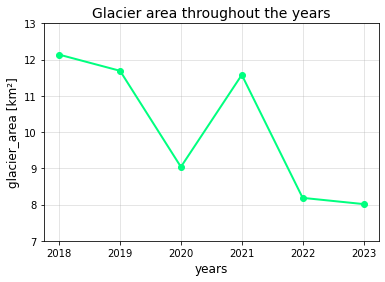

In [19]:
# create a line plot that will show the change in glacier area over the years
plt.plot(years, values, '-o', color='#00ff7f', linewidth=2, markersize=6)
# set labels for x and y axes
plt.xlabel('years', fontsize=12)
plt.ylabel('glacier_area [km²]', fontsize=12)

# set title
plt.title('Glacier area throughout the years', fontsize=14)

# set limits of y axis and plot grid
plt.ylim(bottom=7, top=13)
plt.grid(alpha=0.4)

# display the plot
plt.show()